In [1]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import pandas as pd
import pymaster as nmt
import scipy.linalg as LA

In [1]:
#import all
import sys
sys.path.append("../lib")
from tqdm import tqdm

import numpy as np
import healpy as hp
import pymaster as nmt 
import pysm3
import time
from mpfit import mpfit
import mpfitlib as mpl
import scipy
#from Nearest_Positive_Definite import *
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.patheffects as path_effects
import scipy.stats as st
import basicfunc as func
import analys_lib as an
import simu_lib as sim
import pysm3.units as u

#sim params

r = 0
nside = 16
Npix = hp.nside2npix(nside)
N= 1000
lmax = nside*3-1
#lmax=850
scale = 10
Nlbin = 10
fsky = 1
dusttype = 0
syncrotype = 0
kw = ''
load=True


# instr param

ifreq=[0,9,21]
instr_name='litebird_full'
instr =  np.load("../lib/instr_dict/%s.npy"%instr_name,allow_pickle=True).item()
freq= instr['frequencies']
sens_P= instr['sens_P']
freq=freq[ifreq]
sens_P=sens_P[ifreq]
sigpix= sens_P/(np.sqrt((4*np.pi)/Npix*(60*180/np.pi)**2))
b = nmt.bins.NmtBin(nside=nside,lmax=lmax,nlb=Nlbin)
leff = b.get_effective_ells()
N_freqs =len(freq)
Ncross=int(N_freqs*(N_freqs+1)/2)

nucross = []
for i in range(0,N_freqs):
    for j in range(i,N_freqs):
        nucross.append(np.sqrt(freq[i]*freq[j]))
nucross = np.array(nucross)


#cmb
CLcmb_or=hp.read_cl('../CLsimus/Cls_Planck2018_r0.fits') #TT EE BB TE
DL_lens = leff*(leff+1)*b.bin_cell(CLcmb_or[2,2:lmax+3])/2/np.pi

#mask
if fsky==1:
    mask =  np.ones(Npix)
else:
    mask = hp.read_map("../masks/mask_fsky%s_nside%s_aposcale%s.npy"%(fsky,nside,scale))

#call foreground sky
if dusttype==None and syncrotype==None:
    mapfg=np.zeros((N_freqs,2,Npix))
else:
    if dusttype==None:
        sky = pysm3.Sky(nside=512, preset_strings=['s%s'%syncrotype])#,'s%s'%synctype])
    if syncrotype==None:
        sky = pysm3.Sky(nside=512, preset_strings=['d%s'%dusttype])#,'s%s'%synctype])
    if syncrotype!=None and dusttype!=None:
        sky = pysm3.Sky(nside=512, preset_strings=['d%s'%dusttype,'s%s'%syncrotype])
    mapfg= np.array([sim.downgrade_map(sky.get_emission(freq[f] * u.GHz).to(u.uK_CMB, equivalencies=u.cmb_equivalencies(freq[f]*u.GHz)),nside_in=512,nside_out=nside) for f in range(len(freq))])
    mapfg=mapfg[:,1:]

#np.save("./test-sim-cov/map-test/mapfg.npy",mapfg)

# call cmb

--------------------------------------------------------------------------

  Local host:   login23
  Local device: mlx5_0
--------------------------------------------------------------------------


In [2]:
# create N sims
noisemaps= np.zeros((N,3,N_freqs,2,Npix))
mapcmb = np.zeros((N,N_freqs,2,Npix))

for k in tqdm(range(0,N)):
    for p in range(3):
        for i in range(N_freqs):
            noisemaps[k,p,i,0] =np.random.normal(0,sigpix[i],size=Npix)
            noisemaps[k,p,i,1] =np.random.normal(0,sigpix[i],size=Npix)
    
    mapcmb0= hp.synfast(CLcmb_or,nside,pixwin=False,new=True)
    mapcmb1 = np.array([mapcmb0 for i in range(N_freqs)])
    mapcmb[k] = mapcmb1[:,1:]


100%|██████████| 1000/1000 [00:02<00:00, 457.32it/s]


In [3]:
#workspace
wsp_dc=[]
for i in range(0,N_freqs): 
    for j in range(i,N_freqs):
        w_dc = nmt.NmtWorkspace()
        if i != j :
            w_dc.compute_coupling_matrix(nmt.NmtField(mask, 1*mapfg[i],purify_e=False, purify_b=True), nmt.NmtField(mask,1*mapfg[j],purify_e=False, purify_b=True), b)
        if i==j :
            w_dc.compute_coupling_matrix(nmt.NmtField(mask, 1*mapfg[i],purify_e=False, purify_b=True), nmt.NmtField(mask, 1*mapfg[j],purify_e=False, purify_b=True), b)
        wsp_dc.append(w_dc)
 
wsp_dc=np.array(wsp_dc)

def computecross(mapauto1,mapauto2,mapcross1,mapcross2):
    CLcross=np.zeros((Ncross,len(leff)))
    z=0
    for i in range(0,N_freqs):
        for j in range(i,N_freqs):
            if i != j :
                CLcross[z]=np.array((sim.compute_master(nmt.NmtField(mask, 1*mapauto1[i],purify_e=False, purify_b=True), nmt.NmtField(mask, 1*mapauto2[j],purify_e=False, purify_b=True), wsp_dc[z]))[3])
            if i==j :
                CLcross[z]=np.array((sim.compute_master(nmt.NmtField(mask, 1*mapcross1[i],purify_e=False, purify_b=True), nmt.NmtField(mask, 1*mapcross2[j],purify_e=False, purify_b=True), wsp_dc[z]))[3])
            z = z +1
    return leff*(leff+1)*CLcross/2/np.pi

DLcross_coadd= np.zeros((N,Ncross,len(leff)))

for k in tqdm(range(0,N)):
    #addition du bruit aux cartes
    mapauto =   mapfg+  noisemaps[k,0] + mapcmb[k]
    mapcross1 =  mapfg+  noisemaps[k,0]*np.sqrt(2) + mapcmb[k]
    mapcross2 =  mapfg+  noisemaps[k,0]*np.sqrt(2) + mapcmb[k]
    DLcross_coadd[k]= computecross(mapauto,mapauto,mapcross1,mapcross2)

DLcross_fg = computecross(mapfg,mapfg,mapfg,mapfg)

100%|██████████| 1000/1000 [01:06<00:00, 14.94it/s]


In [4]:
DL_cross_noise= 2*np.array([leff*(leff+1)*sigpix[i]**2/Npix for i in range(N_freqs)])

In [20]:
def cov_analytic(nu_i,nu_j):
    i = np.argwhere(freq==nu_i)[0,0]
    j = np.argwhere(freq==nu_j)[0,0]
    poscross= np.argwhere(nucross==np.sqrt(nu_i*nu_j))[0,0]
    ncross=len(nucross)
    nnus = int((-1 + np.sqrt(ncross * 8 + 1)) / 2.)
    posauto = [int(nnus * i - i * (i + 1) / 2 + i) for i in range(nnus)]
    auto_i=posauto[i]
    auto_j=posauto[j]
    v_l = (2*leff+1)*Nlbin*fsky
    if nu_i==nu_j:
        DLAB =  DL_lens + 2*DL_cross_noise[i] +DLcross_fg[poscross]
        DLAA =  DL_lens + 2*DL_cross_noise[i] +DLcross_fg[auto_i]
        DLBB =  DL_lens + 2*DL_cross_noise[j] +DLcross_fg[auto_j] 
    else:
        DLAB = DLcross_fg[poscross] + DL_lens
        DLAA = DL_lens + DL_cross_noise[i] +DLcross_fg[auto_i]
        DLBB = DL_lens + DL_cross_noise[j] +DLcross_fg[auto_j]
    return (DLAB**2+DLAA*DLBB - DLcross_fg[auto_i]*DLcross_fg[auto_j]- DLcross_fg[poscross]**2 )/v_l
    #return (DLAB**2+DLAA*DLBB)/v_l

In [21]:
def getcov(DL,ellbin,N):
    return np.cov(np.swapaxes(DL[:N,:,ellbin],0,1))
cov_add=np.array([getcov(DLcross_coadd,l,N) for l in range(len(leff))])

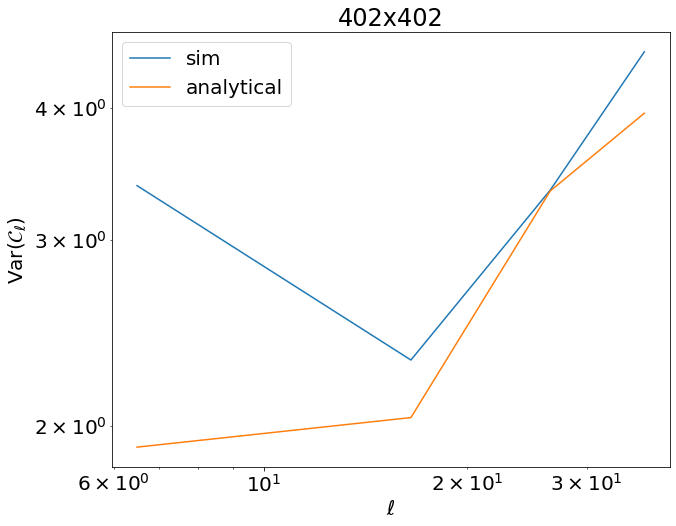

In [22]:
plt.figure(figsize=(10,8))
freq1=402
freq2=402
poscross= np.argwhere(nucross==np.sqrt(freq1*freq2))[0,0]
plt.plot(leff,cov_add[:,poscross,poscross],label='sim')
plt.plot(leff,cov_analytic(freq1,freq2),label='analytical')
plt.title('%sx%s'%(freq1,freq2))
plt.xlabel(r'$\ell$')
plt.ylabel(r'Var$(\mathcal{C}_\ell)$')
plt.loglog()
plt.legend()
plt.show()